## Training a GPT-2 model on small molecule sequences

[Theis et al. (2016)](https://arxiv.org/abs/1511.01844) show that the (negative) log-likelihood (which is used to train many machine learning models) is not a sufficient criteria to decide whether a model training should terminate. Thus, in this notebook, we show how to use seqme's metrics to determine model training stopping criteria. Several models [REF: dirichet flow, MOG] use the FBD as stopping criteria.

https://github.com/szczurek-lab/hyformer/blob/v2.0/data/vocabulary/guacamol.txt

The GPT-2 model is trained on molecules encoded as SMILE sequences from the [GuacaMol dataset](https://figshare.com/projects/GuacaMol/56639). The molecules originates from the ChEMBL dataset. 

In [1]:
# !pip install datasets transformers[torch] "seqme[hyformer_molecules]" "hyformer @ git+https://github.com/szczurek-lab/hyformer.git@main"

In [2]:
%load_ext autoreload
%autoreload 2

import random
from functools import partial
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
from datasets import Dataset, DatasetDict
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments

import seqme as sm

from notebooks.tokenizer import SMILESTokenizer

/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/case_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


In [4]:
set_seed(42)

In [5]:
WORKDIR_PATH = Path("./")

In [6]:
DATA_PATH = WORKDIR_PATH / "data" / "guacamol_v1_all.smiles"

In [7]:
with open(DATA_PATH) as f:
    sequences = f.read().strip().split("\n")

In [8]:
len(sequences)

1591378

In [9]:
sequences = sm.utils.subsample(sequences, n_samples=300_000)

In [10]:
train, val = sklearn.model_selection.train_test_split(sequences, train_size=0.99)

In [11]:
len(train), len(val)

(297000, 3000)

In [12]:
VOCAB_PATH = WORKDIR_PATH / "configs" / "guacamol_vocab.txt"
tokenizer = SMILESTokenizer(VOCAB_PATH, bos_token="[BOS]", eos_token="[EOS]", pad_token="[PAD]", unk_token="[UNK]", mask_token="[MASK]")

In [13]:
def collate_batch(batch, pad_id=tokenizer.pad_token_id, max_len=128):
    input_ids = [x["input_ids"][:max_len] for x in batch]
    labels = input_ids

    max_batch_len = max(len(x) for x in input_ids)
    input_ids = [x + [pad_id] * (max_batch_len - len(x)) for x in input_ids]
    labels = [x + [-100] * (max_batch_len - len(x)) for x in labels]

    attention_mask = [[1] * len(x) + [0] * (max_batch_len - len(x)) for x in input_ids]

    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
    }


In [14]:
@torch.inference_mode()
def generate(
    model,
    n_samples: int,
    *,
    max_length=52,
    top_k: int = 5,
    top_p: float = 0.9,
    batch_size: int = 256,
) -> list[str]:
    BOS_ID = tokenizer.bos_token_id
    PAD_ID = tokenizer.pad_token_id
    input_ids = torch.tensor(
        [[BOS_ID]] * n_samples, dtype=torch.long, device=model.device
    )

    output = []
    for i in range(0, n_samples, batch_size):
        batch = input_ids[i : i + batch_size]
        output_ids = model.generate(
            input_ids=batch,
            max_length=max_length,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=PAD_ID,
        )
        output += tokenizer.batch_decode(output_ids)

    return output


In [15]:
dataset_train = Dataset.from_dict({"text": train})
dataset_valid = Dataset.from_dict({"text": val})
dataset = DatasetDict({"train": dataset_train, "validation": dataset_valid})

tokenized_dataset = dataset.map(
    tokenizer, remove_columns=["text"], batched=True, input_columns=["text"]
)

Map: 100%|██████████| 3000/3000 [00:00<00:00, 50012.77 examples/s]


In [16]:
model = GPT2LMHeadModel(
    GPT2Config(
        vocab_size=tokenizer.vocab_size,
        n_positions=128,
        n_embd=256,
        n_layer=8,
        n_head=8,
    )
)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print(
    "Trainable parameters:",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

Total parameters: 6378752
Trainable parameters: 6378752


In [17]:
n_sequences = 2048
dfs = []

hyformer = sm.models.Hyformer(sm.models.HyformerCheckpoint.molecules_50M)

metrics = [
    sm.metrics.Uniqueness(),
    sm.metrics.FBD(val, hyformer),
    sm.metrics.MMD(val, hyformer, device="cuda"),
    sm.metrics.Recall(
        n_neighbors=5, reference=val, embedder=hyformer, strict=False, device="cuda"
    ),
    sm.metrics.Precision(
        n_neighbors=5, reference=val, embedder=hyformer, strict=False, device="cuda"
    ),
]


def compute_metrics(eval_pred):
    sequences = partial(generate, model)(n_sequences)

    row_name = ("GPT-2", len(dfs))
    df = sm.evaluate({row_name: sequences}, metrics, verbose=False)
    dfs.append(df)

    return {
        f"val/{metric.name}": df[(metric.name, "value")][row_name] for metric in metrics
    }

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/case_env/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch

Model state_dict loaded with strict=True.


In [18]:
training_args = TrainingArguments(
    output_dir="./molecule_gpt_small",
    overwrite_output_dir=True,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    num_train_epochs=500,
    learning_rate=5e-4,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="epoch",
    logging_steps=1000,
    report_to="none",
    torch_compile=True,
    # fp16=False,
    # use_cpu=True,
    # save_steps=50_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collate_batch,
    compute_metrics=compute_metrics,
)

trainer.train()


{'loss': 1.0293, 'grad_norm': 0.4538004696369171, 'learning_rate': 0.0004982805507745267, 'epoch': 1.721170395869191}
{'eval_loss': 0.7445569634437561, 'eval_val/Uniqueness': 1.0, 'eval_val/FBD': 96.69023210384535, 'eval_val/MMD': 3.9139287546277046, 'eval_val/Recall': 0.589, 'eval_val/Precision': 0.9404296875, 'eval_runtime': 13.0123, 'eval_samples_per_second': 230.551, 'eval_steps_per_second': 0.461, 'epoch': 1.721170395869191}
{'loss': 0.7258, 'grad_norm': 0.788743793964386, 'learning_rate': 0.0004965593803786575, 'epoch': 3.442340791738382}
{'eval_loss': 0.6683120131492615, 'eval_val/Uniqueness': 1.0, 'eval_val/FBD': 79.4846758866845, 'eval_val/MMD': 3.1310580670833588, 'eval_val/Recall': 0.6373333333333333, 'eval_val/Precision': 0.970703125, 'eval_runtime': 6.6687, 'eval_samples_per_second': 449.865, 'eval_steps_per_second': 0.9, 'epoch': 3.442340791738382}
{'loss': 0.6673, 'grad_norm': 0.2369193434715271, 'learning_rate': 0.0004948382099827883, 'epoch': 5.163511187607573}
{'eval_

KeyboardInterrupt: 

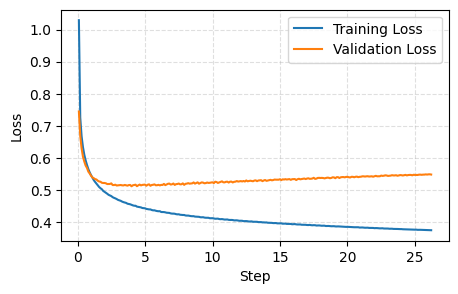

In [19]:
train_loss = [
    (dv["step"], dv["loss"]) for dv in trainer.state.log_history if "loss" in dv
]
val_loss = [
    (dv["step"], dv["eval_loss"])
    for dv in trainer.state.log_history
    if "eval_loss" in dv
]

train_steps, train_values = zip(*train_loss, strict=True)
val_steps, val_values = zip(*val_loss, strict=True)

val_steps = np.array(val_steps) / 10_000
train_steps = np.array(train_steps) / 10_000

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(train_steps, train_values, label="Training Loss")
ax.plot(val_steps, val_values, label="Validation Loss")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [20]:
df_all = sm.combine(dfs)

In [21]:
sm.to_pickle(df_all, "gpt2.pkl")

In [22]:
df_all.index = pd.MultiIndex.from_arrays([df_all.index.get_level_values(0), val_steps])

In [23]:
def insert(
    df: pd.DataFrame,
    name: str,
    values: np.ndarray,
    objective: Literal["minimize", "maximize"],
) -> pd.DataFrame:
    df = df.copy()
    df[(name, "value")] = values
    df[(name, "deviation")] = float("nan")
    df.attrs["objective"][name] = objective
    return df

In [24]:
df_all = insert(df_all, "Perplexity", np.exp(val_values), "minimize")

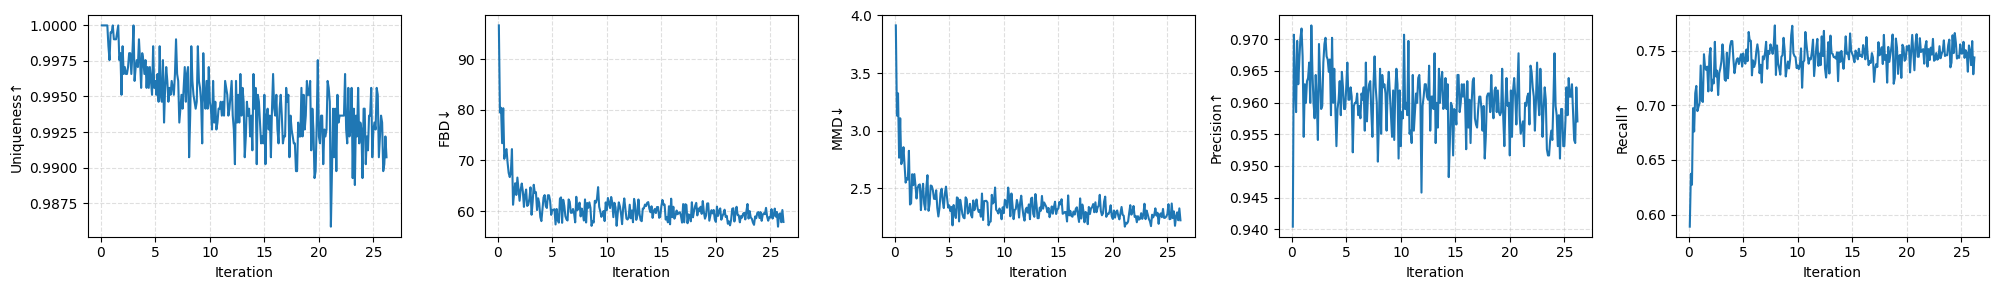

In [25]:
metrics_to_show = ["Uniqueness", "FBD", "MMD", "Precision", "Recall"]

fig, axes = plt.subplots(
    nrows=1, ncols=len(metrics_to_show), figsize=(len(metrics_to_show) * 4, 3)
)

for i, name in enumerate(metrics_to_show):
    sm.plot_line(df_all, metric=name, ax=axes[i], marker=None)
    axes[i].get_legend().remove()

fig.tight_layout()

In [26]:
cmap = plt.get_cmap("viridis")
K = len(df_all)
colors = [cmap(i / (K - 1)) for i in range(K)]

df_flat = df_all.xs("GPT-2", level=0)

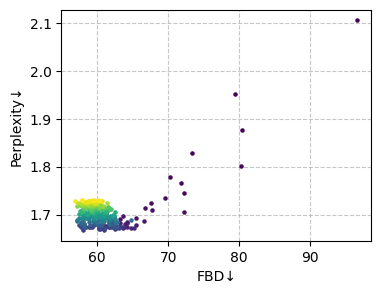

In [27]:
fig, ax = plt.subplots(figsize=(4, 3))
sm.plot_scatter(df_flat, ["FBD", "Perplexity"], marker_size=5, ax=ax, color=colors)
ax.get_legend().remove()

In [28]:
df_all = sm.rank(df_all, metrics=["MMD", "Recall", "Precision"])

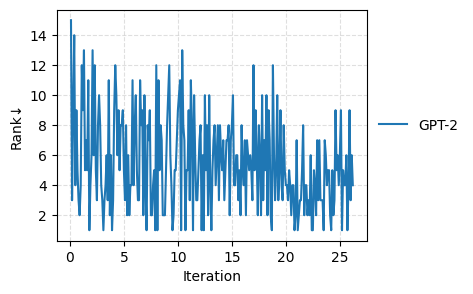

In [29]:
sm.plot_line(df_all, metric="Rank", marker=None)

In [30]:
generated_sequences = generate(model, n_samples=10, max_length=128)

In [31]:
for peptide in generated_sequences:
    print(len(peptide), peptide)

111 COc1cccc(Nc2nc(-c3ccccc3)nc3ccc(F)cc23)c1c1cccnc1COc1ccc(N(C)C)cc1c1ccccc1ccc1CO(C)=OOCcc1c1ccccccccccccccccccc
117 COc1ccc2[nH]c(SCc3cc(=O)n(CC(=O)Nc4ccccc4Cl)nc3Cl)nc2c1c1ccccc1c1ccccc1n1n1ccnc1c1ccccc1Cccccccccccccccccccccccccccc1
119 CCC(C)C(NC(=O)C(C)NC(=O)C(CCCNC(=N)N)NC(=O)OCc1ccccc1)C(=O)NC(CCCNC(=N)N)C(=O)NC(CC(C)C)C(=O)OC(=O)OOOOOOc1c2CCCCC(=NC(
110 CC1(C)OCC(COc2ccc3c(c2)C(=O)c2cccc(O)c2C3=O)O1C(=O)OOC(C)(C)COC(=O)C(C)(C)C(COS(=O)(=O)OCOOOOOOC(CC(=OOOOCc1OO
116 COc1ccc(-c2cc(-c3ccc(Cl)cc3)nc3c2COc2ccc(F)cc2-3)cc1(OC)C(O)C(=O)Oc1ncccc1Cc1ccccc1c1ccccc1ccccccccc1cccccccccccccc1
112 CCOc1ccccc1NC(=O)C1CCCN(c2nnc(C)c3c(C)n(-c4ccccc4)nc23)C1S(=O)(=O)c1ccccc1c1ccccc1CCc1cccccnccccccc1(CccccccccOO
120 O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2ccccc2C1CN1CCC(O)C1c1ccccc1c1ccccc1cc(Cl)cc1c1cc(Br)cc1cccc1c1cccc1cccccccccccccccccccccccc1
105 Cc1cc(C)n2nc(SCc3nc(-c4ccccc4F)oc3C)nc2n1n1nnc2ccccc2c1=O[n+]1scnc1N(C)CC2ccccc12CN(C)CCCCCCCCCCcCCCCC(C(
97 Cc1ccc(S(=O)(=O)N2CCN(C(=O)c3ccncc3)CC2)cc1CC(O